# Multi-Class Image Classification for Robust Outdoor Weather Recognition


**Authors**: [Dominic Muli](mailto:dominic.muli@student.moringaschool.com), [Evangeline Ngunjiri](mailto:evangeline.ngunjiri@student.moringaschool.com), and [Ivy Ndunge](mailto:ivy.ndunge@student.moringaschool.com)

## 1.0) Project Overview

## 1.1) Business Problem

## 1.2) Objectives

## 1.3) Metric of Success

## 1.4) Understanding Data


https://data.mendeley.com/datasets/4drtyfjtfy/1?ref=hackernoon.com

## 1.5) Data Relevance and Validation

## 2.0) Reading and Understanding the Data

In [2]:
# installations
# %pip install tensorflow
# %conda install -c conda-forge scikit-image
# %pip install pillow
# %pip install tqdm
# %pip install --upgrade numpy
# %pip install --upgrade scipy


Requirement already up-to-date: scipy in c:\users\dominc\anaconda3\envs\learn-env\lib\site-packages (1.10.1)
  Using cached numpy-1.24.4-cp38-cp38-win_amd64.whl (14.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'C:\\Users\\Dominc\\anaconda3\\envs\\learn-env\\Lib\\site-packages\\~~mpy\\.libs\\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.



In [2]:
# importing necessary libraries
import os, shutil
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib 
from matplotlib import pyplot as plt
import random
from collections import Counter
from tqdm import tqdm
from PIL import Image
from scipy import ndimage
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# from skimage.metrics import structural_similarity as ssim
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
np.random.seed(123)

%matplotlib inline

In [3]:
# reading the data

# path to the dataset
dataset_path = './data/dataset2/'

# List of supported weather classes based on file naming conventions
weather_classes = ['cloudy', 'rain', 'shine', 'sunrise']

# Dictionary to map weather class names to numerical labels
label_map = {weather_class: idx for idx, weather_class in enumerate(weather_classes)}

images = []
labels = []

# Function to extract class label from filename
def extract_label(filename):
    for weather_class in weather_classes:
        if weather_class in filename:
            return label_map[weather_class]
    return None

# Loop through each image file in the dataset directory
for img_file in tqdm(os.listdir(dataset_path), desc='Processing images'):
    img_path = os.path.join(dataset_path, img_file)
    
    try:
        # Open image using PIL
        img = Image.open(img_path)
        
        # Convert image to numpy array
        img = np.array(img)
        
        # Extract class label from the filename
        label = extract_label(img_file)
        
        if label is not None:
            # Append the image and its label to the lists
            images.append(img)
            labels.append(label)
    except Exception as e:
        print(f"Error processing image '{img_file}': {e}")

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

print(f"Total images: {len(images)}")
print(f"Total labels: {len(labels)}")



Processing images: 100%|██████████| 1125/1125 [00:16<00:00, 69.44it/s]

Total images: 1125
Total labels: 1125


## 2.1) Data Splitting

In [4]:
# Splitting data into train, validation, and test sets
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=test_ratio, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio/(train_ratio+val_ratio), random_state=42)

## 2.2) EDA before Preprocessing

<ipython-input-5-f796d6bcd4b3>:12: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(5, num_samples/5, i + 1)


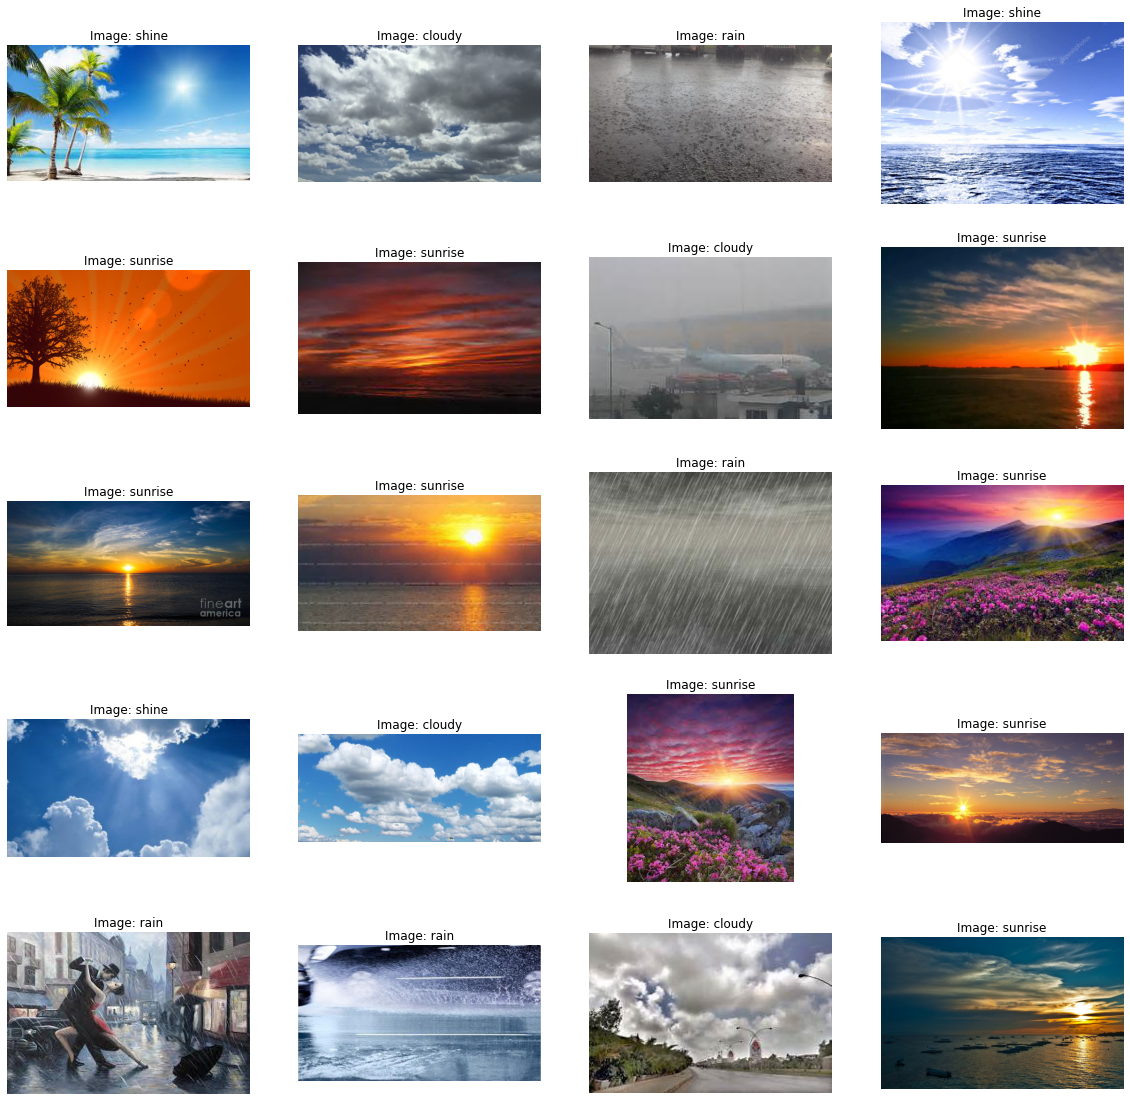

In [5]:
# previewing random images

def visualize_random_images(num_samples=20):
    plt.figure(figsize=(20, 20))
    for i in range(num_samples):
        random_idx = random.randint(0, len(images) - 1) 
        random_image = images[random_idx]
        
        filename = [key for key, value in label_map.items() if value == labels[random_idx]][0]
        
        # Displaying the image
        plt.subplot(5, num_samples/5, i + 1)
        plt.imshow(random_image)
        plt.title(f"Image: {filename}") # using class label as a title
        plt.axis("off")
    plt.show()

visualize_random_images()


In [6]:
# number of images in split data
print('There are', len(X_train), 'outdoor weather images in the training set')
print('There are', len(X_val), 'outdoor weather images in the validation set')
print('There are', len(X_test), 'outdoor weather images in the test set')

There are 787 outdoor weather images in the training set
There are 169 outdoor weather images in the validation set
There are 169 outdoor weather images in the test set


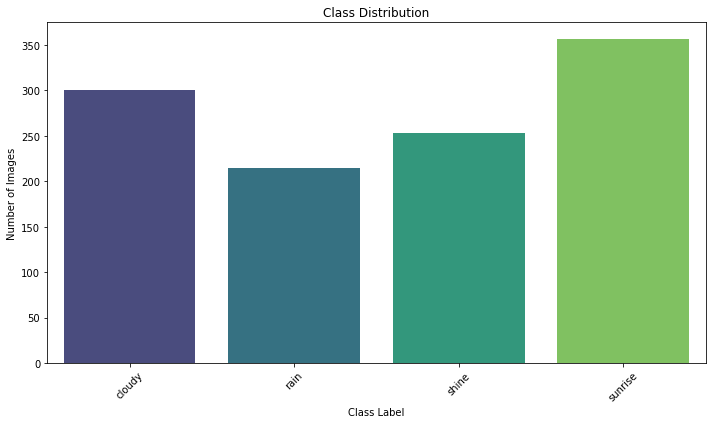

Counter({0: 300, 1: 215, 2: 253, 3: 357})

In [7]:
# class Distribution Visualization

# Get class titles from the label_map
class_titles = [key for key in label_map.keys()]

# Calculate class distribution using Counter
class_distribution = Counter(labels)

plt.figure(figsize=(10, 6))
sns.barplot(x=class_titles, y=list(class_distribution.values()), palette='viridis')
plt.xlabel("Class Label")
plt.ylabel("Number of Images")
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
class_distribution

Processing images:   0%|          | 0/1125 [00:00<?, ?it/s]

Processing images: 100%|██████████| 1125/1125 [00:00<00:00, 1543.32it/s]


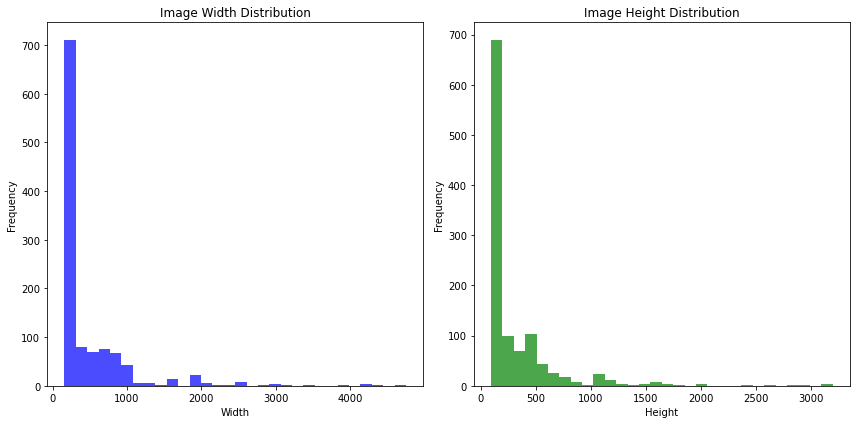

In [8]:
# image size distribution
image_sizes = []
for img_file in tqdm(os.listdir(dataset_path), desc='Processing images'):
    img_path = os.path.join(dataset_path, img_file)
    img = Image.open(img_path)
    width, height = img.size
    image_sizes.append((width, height))

widths, heights = zip(*image_sizes)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(widths, bins=30, color='blue', alpha=0.7)
plt.title('Image Width Distribution')
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.subplot(1, 2, 2)
plt.hist(heights, bins=30, color='green', alpha=0.7)
plt.title('Image Height Distribution')
plt.xlabel('Height')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

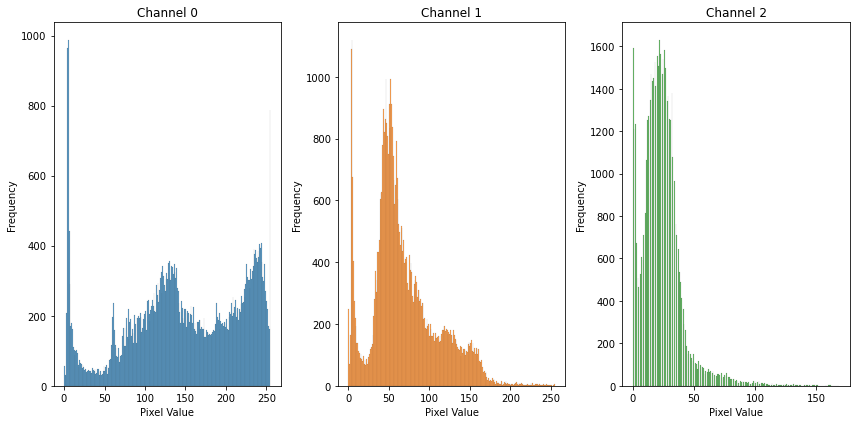

In [9]:
# Convert image to a NumPy array
img_array = np.array(img)

# Display pixel value distributions
plt.figure(figsize=(12, 6))

# Plot histograms for each color channel
for i in range(img_array.shape[2]):
    plt.subplot(1, 3, i + 1)
    sns.histplot(img_array[:, :, i].ravel(), bins=256, color=f'C{i}', alpha=0.7)
    plt.title(f'Channel {i}')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

plt.tight_layout()

In [ ]:
# checking for duplicated images


## 2.3) Data Preprocessing

## 2.4) Building Model

In [ ]:
# Creating a simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_width, image_height, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, epochs=10, validation_data=val_generator)


## 2.5) Conclusion

## 2.6) Recommendation